In [1]:
#CS5228 project

# data manipulation
import pandas as pd
import numpy as np
import math
import random
import pickle
import torch.optim as optim
from scipy import stats


# visualiation
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_selection import RFE # for feature selection of LR
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


In [8]:
#load into dataframe
f_data = pd.read_csv('financial_data.csv', na_values=['?']) 
revealed = pd.read_csv('revealed_businesses.csv')
t_data = pd.read_csv('testing_data.csv', na_values=['?'])
f_data_merged = f_data.merge(revealed)
f_data_revealed = f_data_merged[f_data_merged.Var66 != np.nan]

f_data_positive = f_data_revealed[f_data_revealed.Var66 == 0]
f_data_negative = f_data_revealed[f_data_revealed.Var66 == 1]

columns_no_index = list(f_data_merged.drop(columns=['Var1', 'Var66']))

In [11]:
#Data Cleaning
#display(f_data.isna().sum().sort_values(ascending=False))
#f_data_2 = f_data.drop(columns=['Var38', 'Var22', 'Var61', 'Var28', 'Var61']) #Use in case of column reduction
#columns_no_output = list(f_data_2)  #Use in case of column reduction
#t_data_reduced = t_data[columns_no_output]

f_data_positive_clean = f_data_positive.fillna(method='ffill')
f_data_positive_clean = f_data_positive_clean.dropna()
f_data_negative_clean = f_data_negative.fillna(method='ffill')
f_data_negative_clean = f_data_negative_clean.dropna()

f_data_merged_clean = f_data_positive_clean.append(f_data_negative_clean).sort_index() 
f_data_no_index = f_data_merged_clean.drop(columns=['Var1', 'Var66']) #X Training
training_y = f_data_merged_clean.Var66 #Y training
columns_no_index = list(f_data_no_index)

f_data_positive_no_output = f_data_positive_clean.drop(columns=['Var66'])
f_data_negative_no_output = f_data_negative_clean.drop(columns=['Var66'])

t_data_clean = t_data.fillna(method='bfill').drop(columns=['Var1'])
cID = t_data['Var1'].tolist()
t_data_columns = list(t_data_clean)






#f_data_limited = variance_threshold_selector(f_data_no_index_no_outliers, 0.8) #x for training
#f_data_limited_output = f_data_limited.copy(deep='true')
#f_data_limited_output['Var66'] = training_y
#columns_no_index_limited = list(f_data_limited_output)

Distribution of columns of Vanilla Dataset:

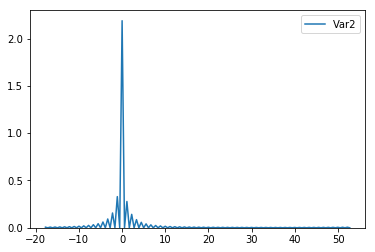

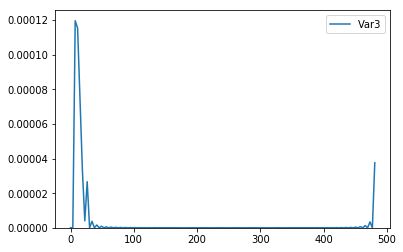

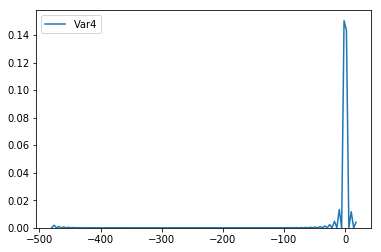

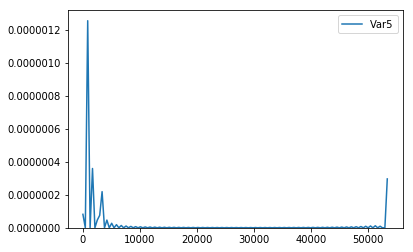

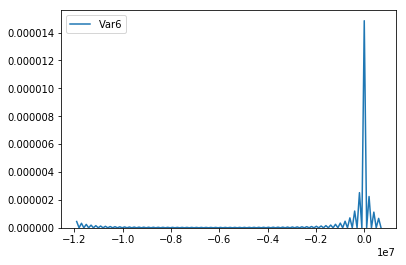

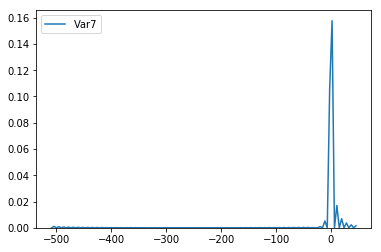

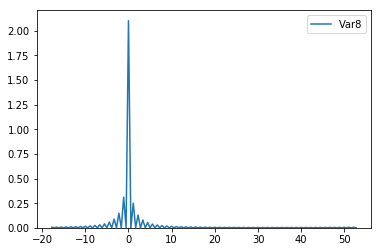

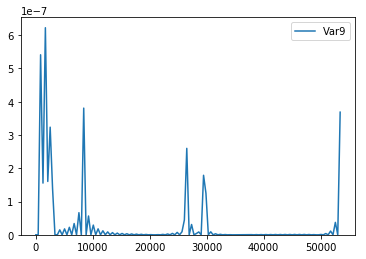

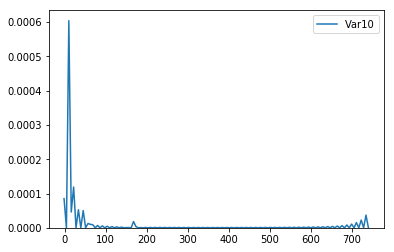

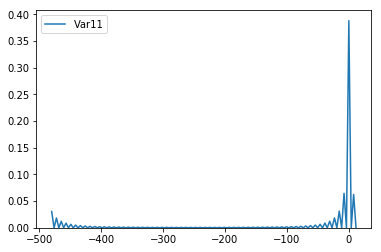

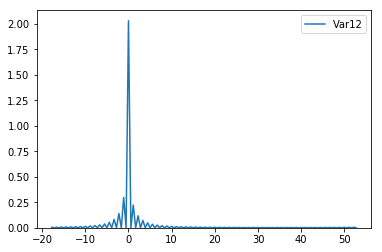

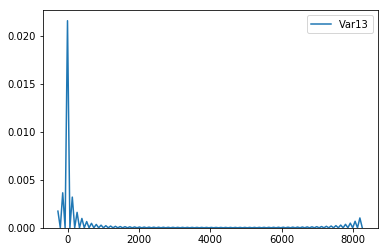

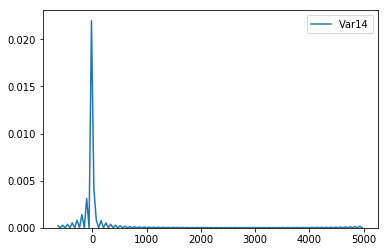

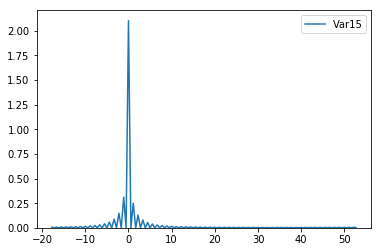

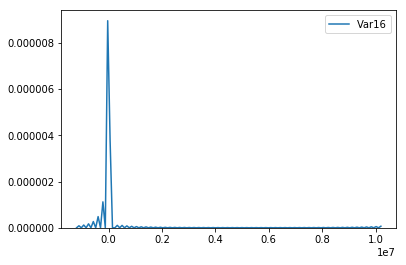

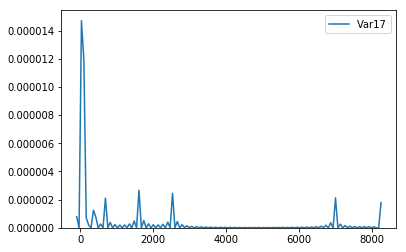

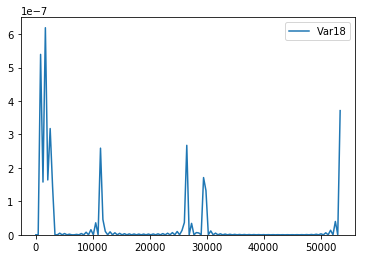

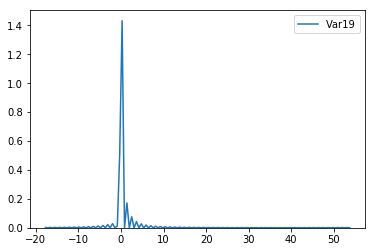

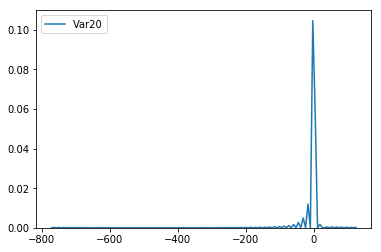

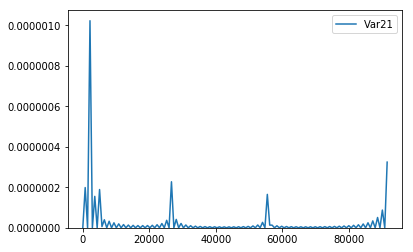

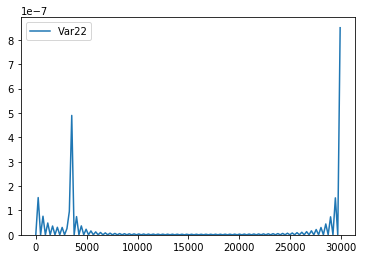

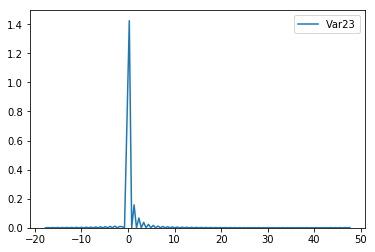

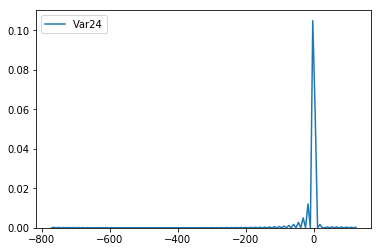

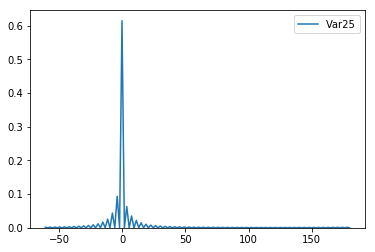

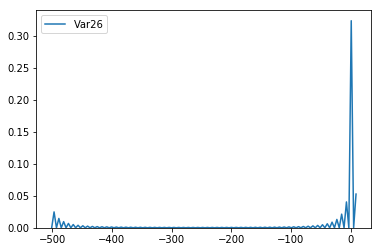

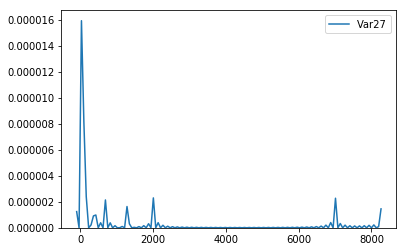

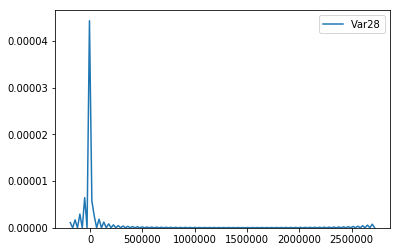

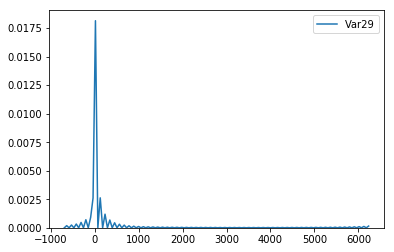

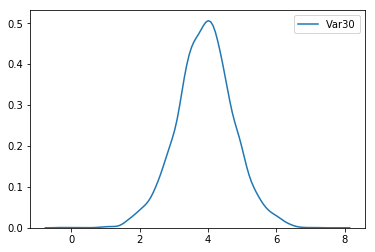

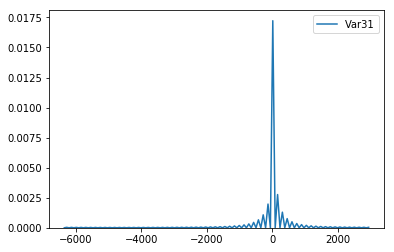

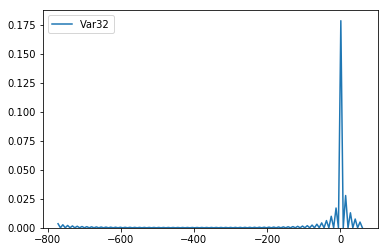

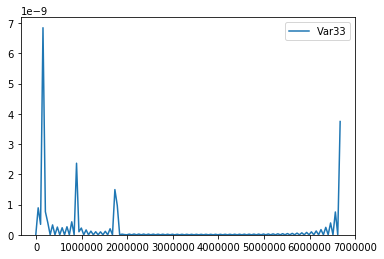

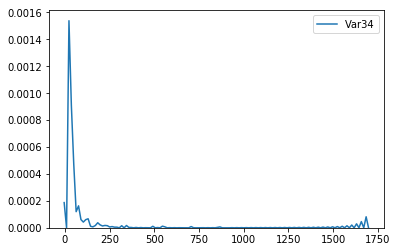

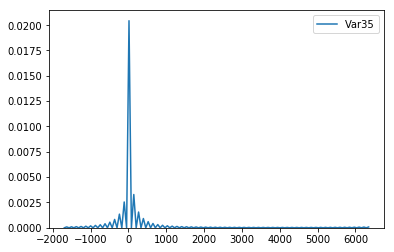

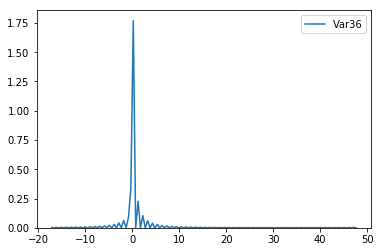

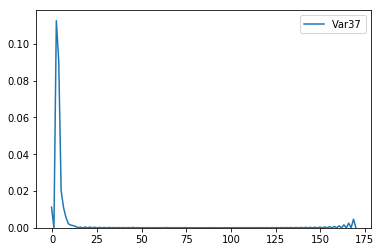

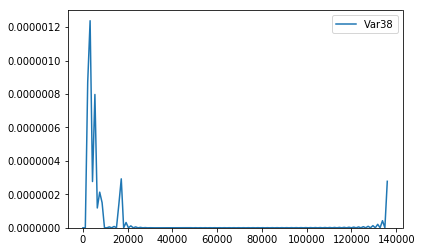

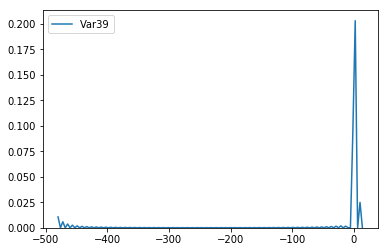

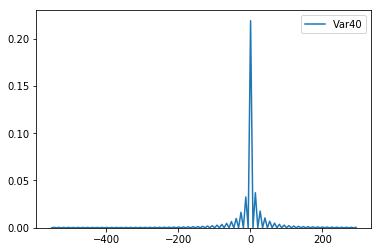

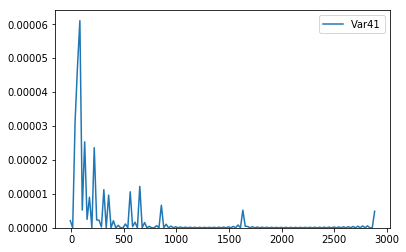

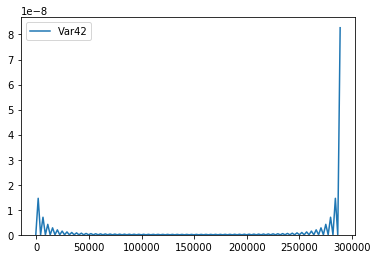

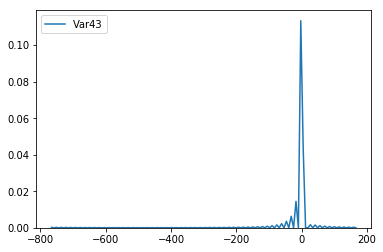

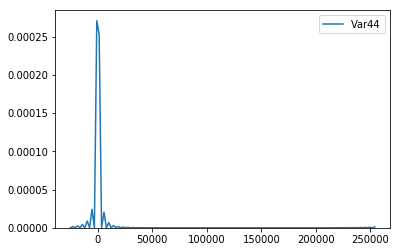

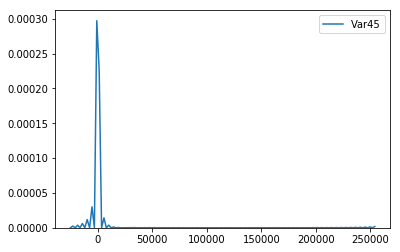

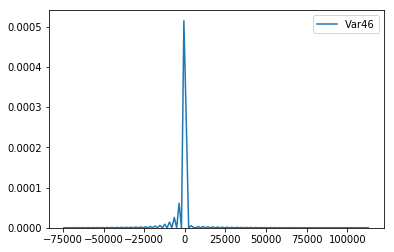

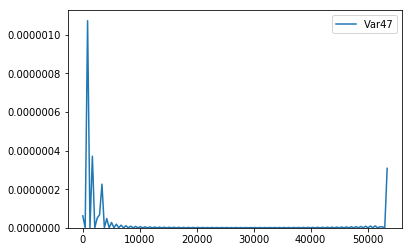

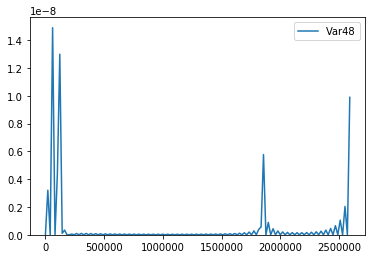

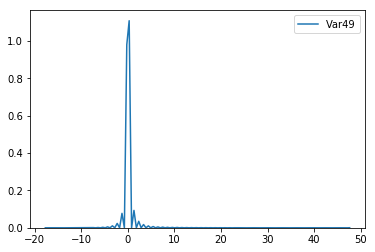

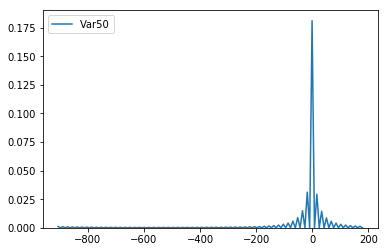

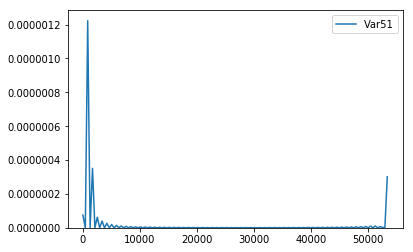

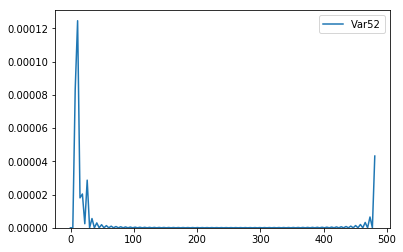

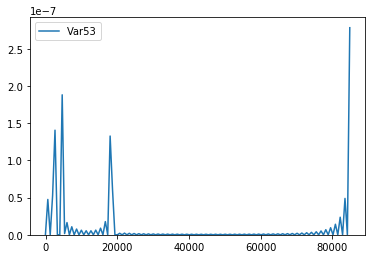

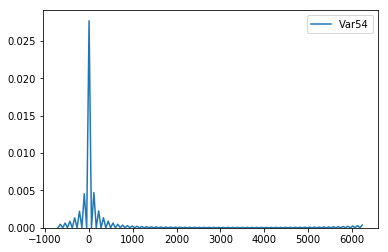

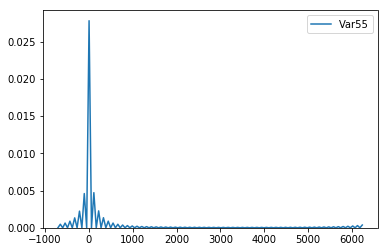

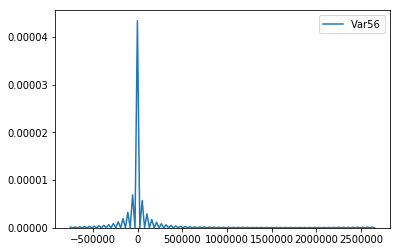

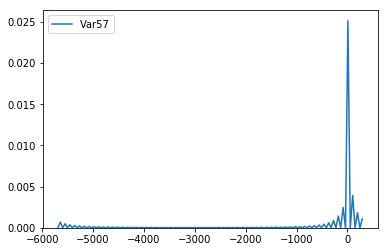

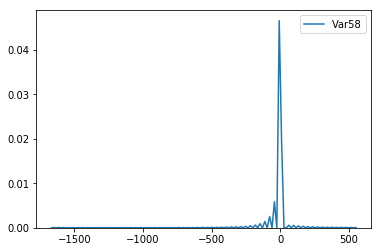

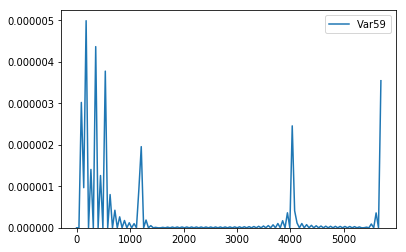

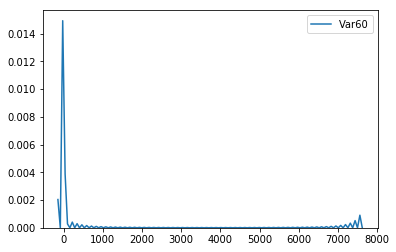

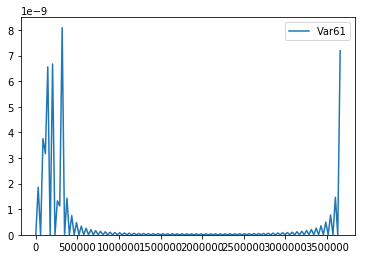

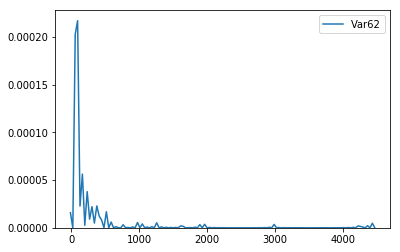

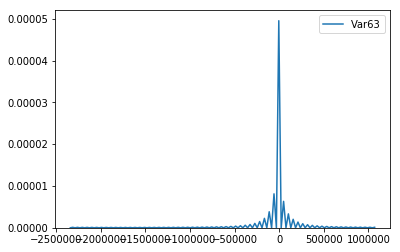

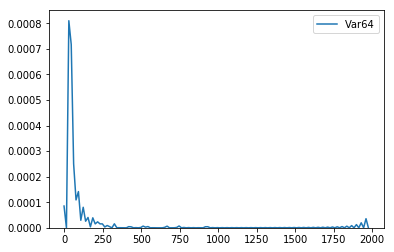

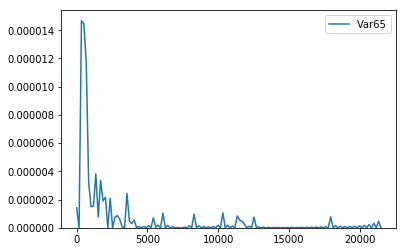

In [9]:
for column in columns_no_index:
    plt.figure()
    display(sb.kdeplot(f_data[column]))

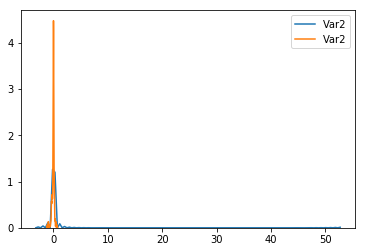

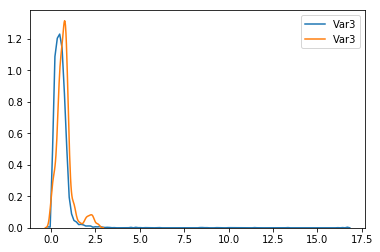

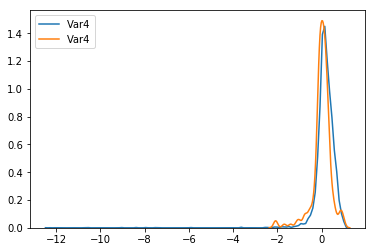

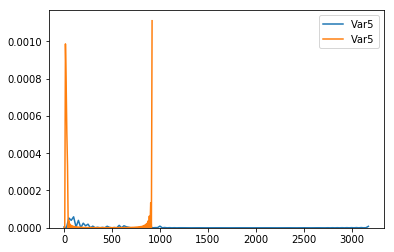

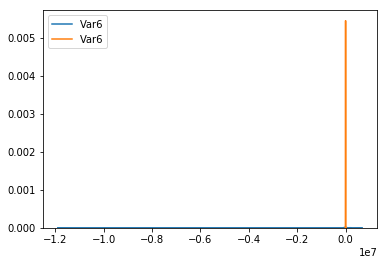

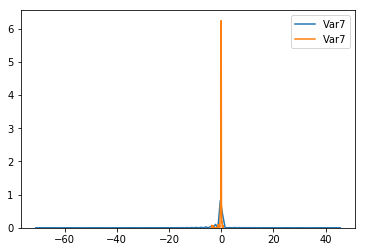

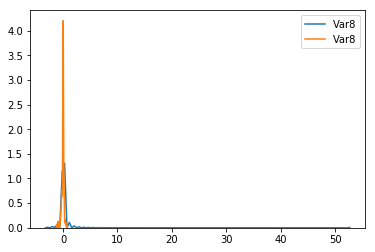

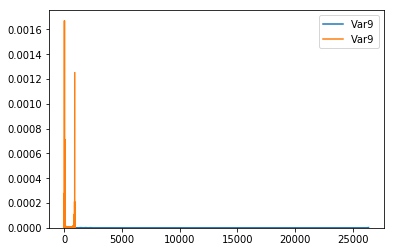

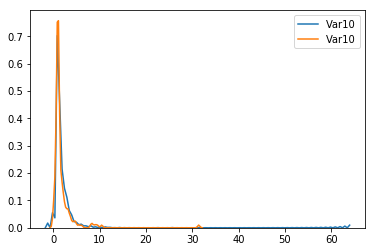

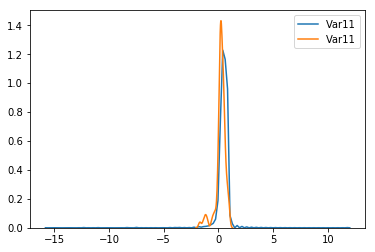

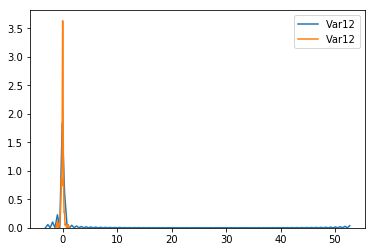

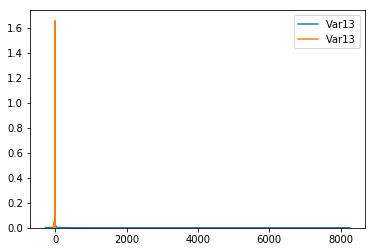

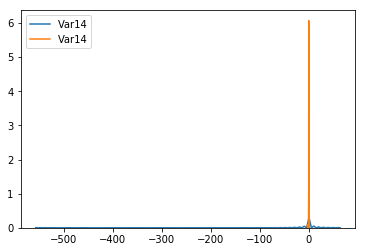

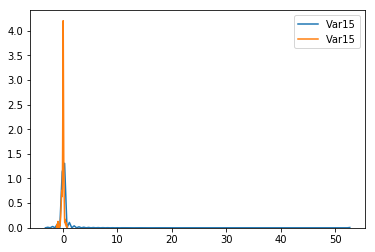

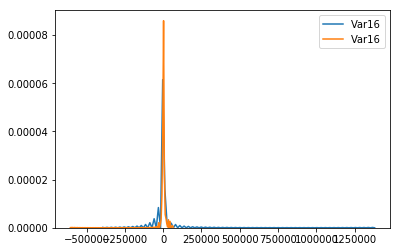

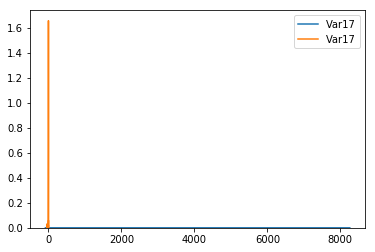

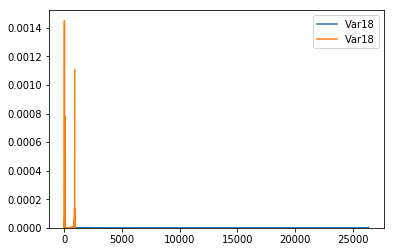

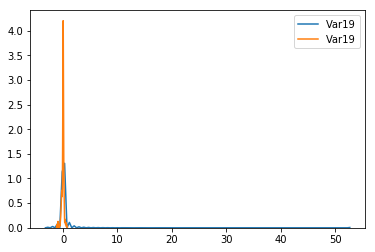

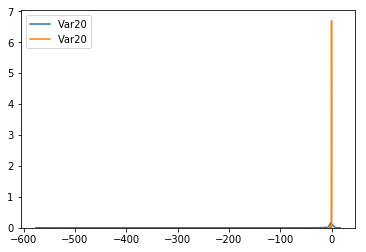

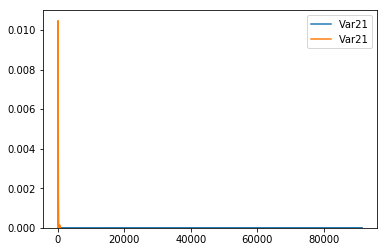

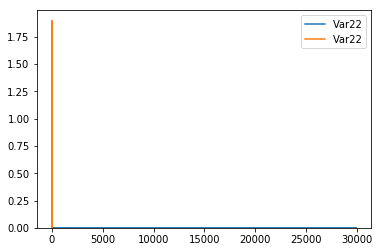

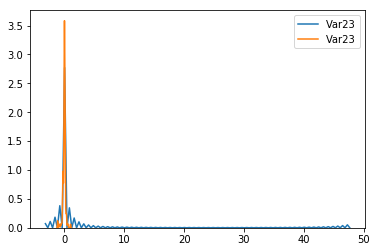

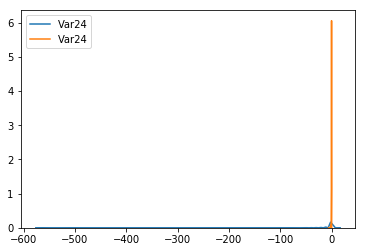

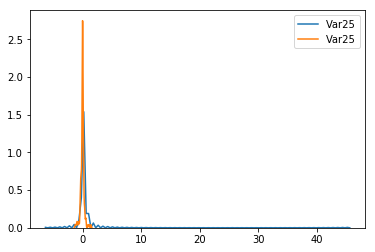

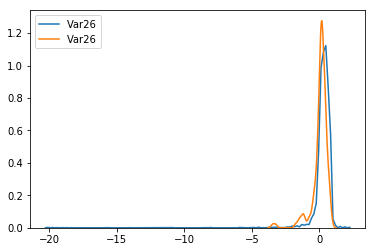

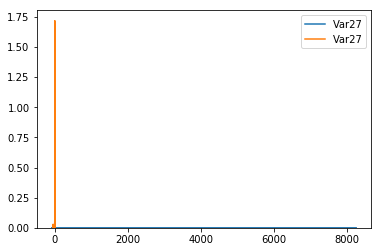

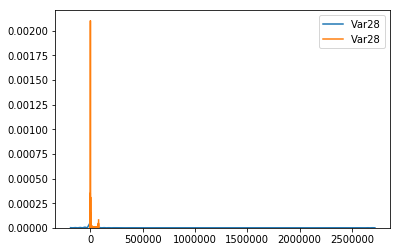

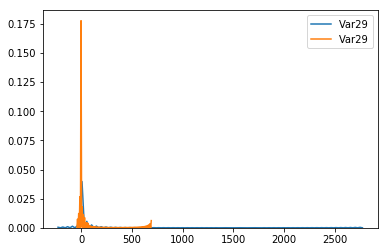

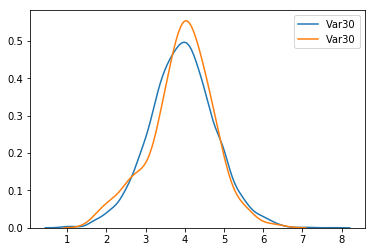

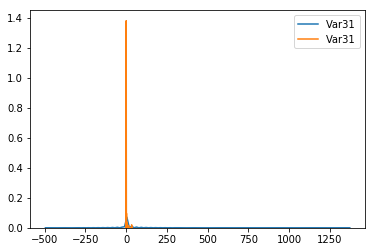

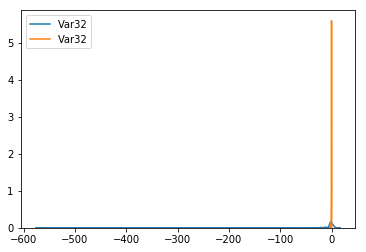

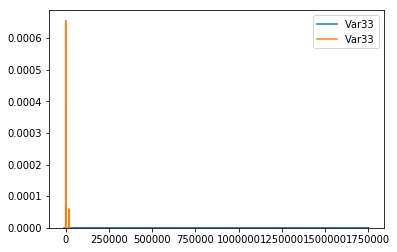

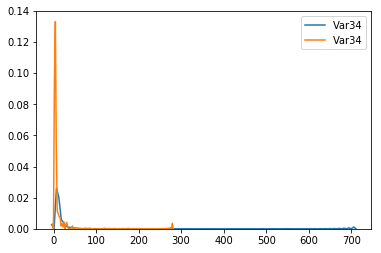

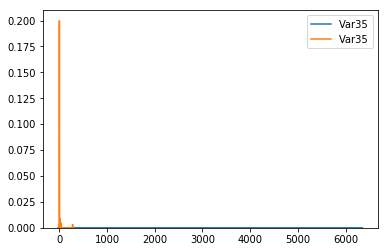

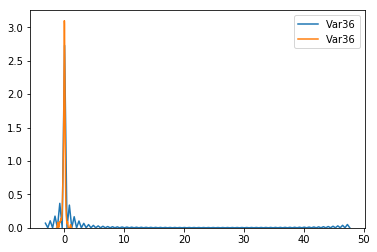

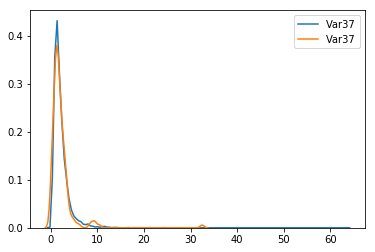

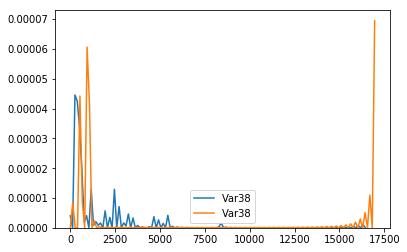

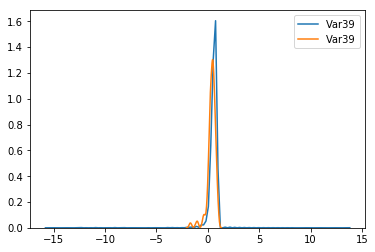

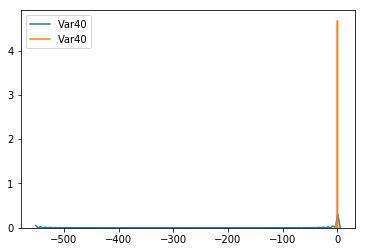

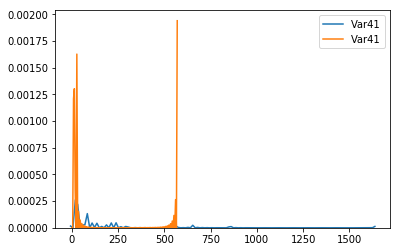

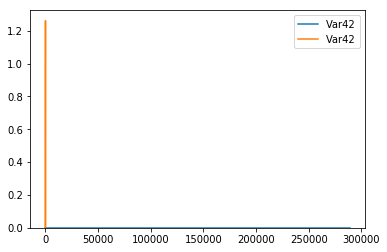

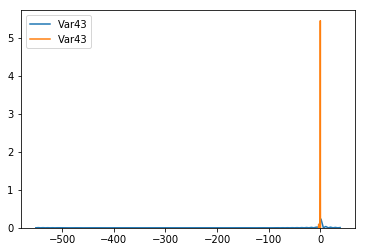

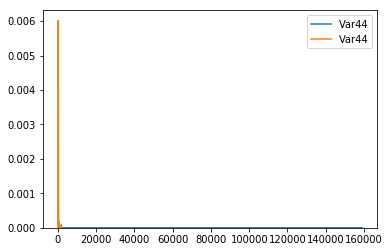

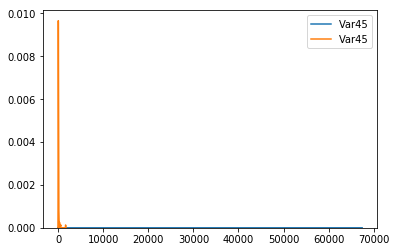

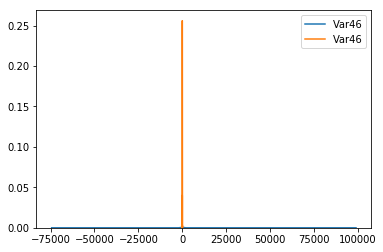

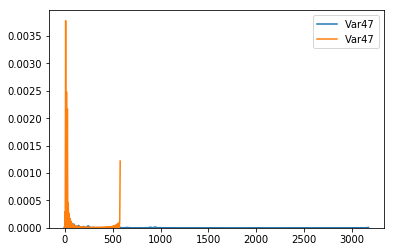

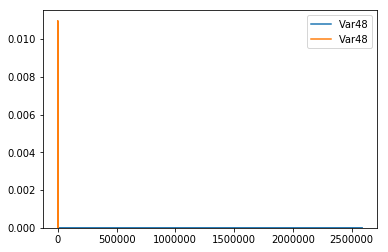

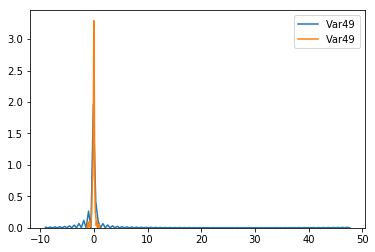

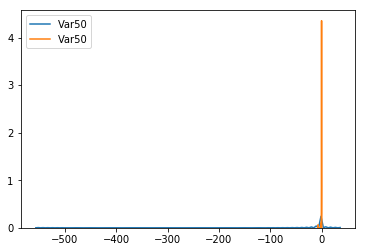

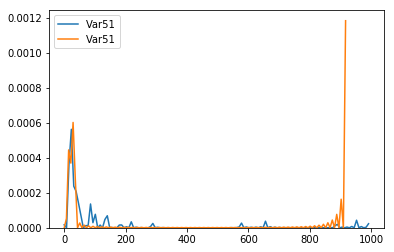

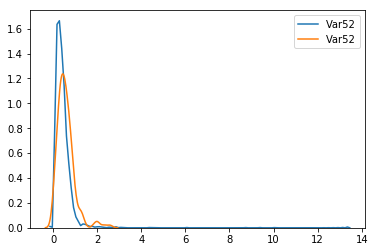

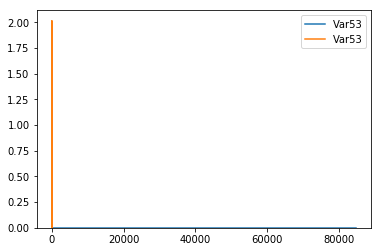

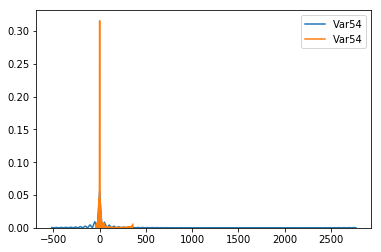

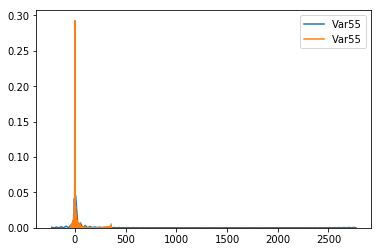

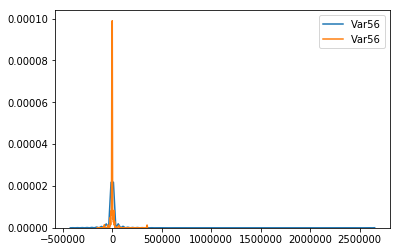

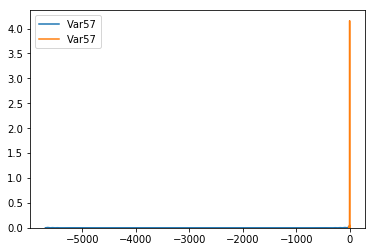

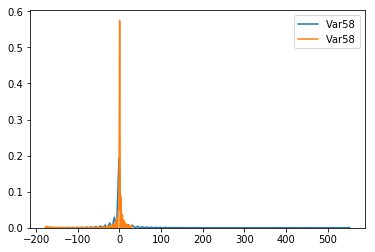

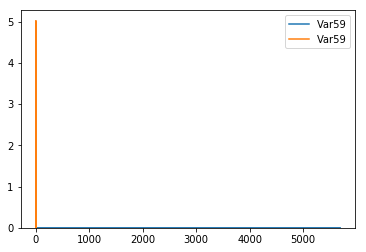

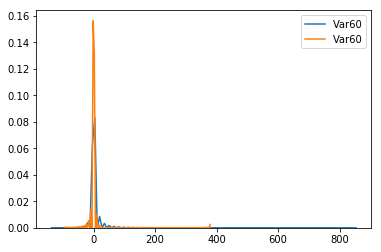

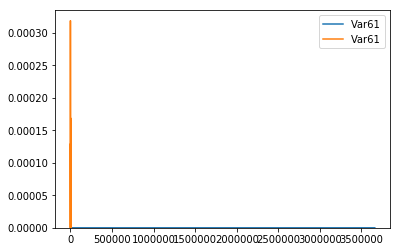

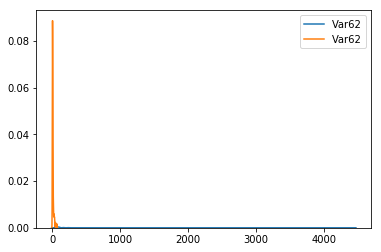

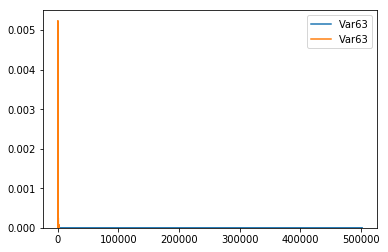

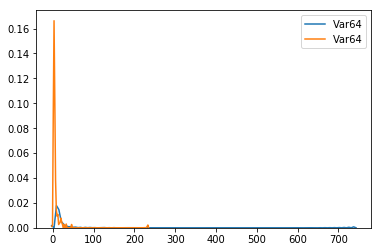

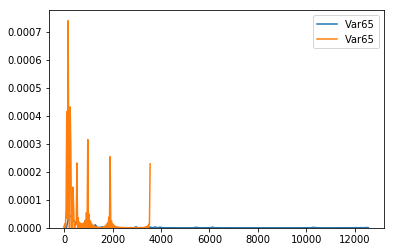

In [12]:
for column in columns_no_index:
    plt.figure()
    display(sb.kdeplot(f_data_positive_clean[column]))
    display(sb.kdeplot(f_data_negative_clean[column]))

In [5]:
#display(f_data.isna().sum())
#display(f_data_merged_clean.isnull().sum())
#display(f_data_revealed.isnull().sum())
#display(f_data_merged_clean.Var66)


Data Normalizing:

In [39]:
scaler = StandardScaler()

f_data_norm = scaler.fit_transform(f_data_no_index)
f_data_normalized = pd.DataFrame(f_data_norm, columns=columns_no_index)

t_data_norm = scaler.fit_transform(t_data_clean)
t_data_normalized = pd.DataFrame(t_data_norm, columns=t_data_columns)

display(f_data_normalized.head())
display(t_data_normalized.head())

,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,...,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65
0,-0.031578,-0.217947,-0.023833,-0.065522,0.016436,0.043052,-0.028107,-0.024453,-0.442741,0.158892,...,0.135385,0.014975,-0.010964,-0.015799,-0.038823,-0.016877,-0.103804,-0.027241,-0.213160,-0.088586
1,-0.114623,0.474405,-0.028456,-0.069338,0.016689,0.017261,-0.128480,-0.027264,-0.020177,-0.428242,...,-0.114428,0.014054,-0.036933,-0.015734,-0.044719,-0.016877,-0.134625,-0.016933,-0.303888,0.043696
2,-0.310244,0.519723,-0.142454,-0.065566,0.016455,0.017261,-0.323589,-0.027363,-0.643001,-0.471554,...,-0.104362,0.011261,-0.154133,-0.012374,0.028404,-0.016767,-0.122845,-0.022144,-0.273064,-0.096589
3,-0.147664,0.124218,-0.853632,-0.081879,0.015869,0.017261,-0.164845,-0.026206,-0.364337,-0.093558,...,-0.156144,0.014151,-0.034607,-0.015302,-0.044719,-0.016792,-0.088503,-0.016169,-0.307144,-0.094299
4,-0.187001,0.803238,-0.805485,-0.077174,0.022185,0.017261,-0.200669,-0.027868,0.742657,-0.742599,...,-0.147965,0.014853,0.613947,-0.015536,-0.194292,0.001046,-0.110785,-0.024033,-0.256083,-0.060590


,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,...,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65
0,0.111465,-0.059198,0.082161,0.070248,0.214767,0.025733,0.090308,-0.023223,-0.466343,0.060784,...,-0.081084,0.495542,0.030066,-0.026149,-0.058331,-0.082314,-0.123844,-0.033871,-0.078187,0.007340
1,0.312120,0.003717,0.016274,-0.129639,0.017576,-0.046425,0.351322,-0.031098,0.313527,-0.002135,...,-0.086097,0.383066,0.265854,-0.026013,-0.058331,-0.072837,-0.127529,-0.025458,-0.166636,-0.003845
2,-0.040492,-0.054128,0.046884,-0.059575,0.048355,0.025733,-0.060728,-0.025999,-0.054489,0.055714,...,-0.046986,1.034808,0.013795,-0.026707,-0.058331,-0.086497,-0.075128,-0.035621,-0.023507,-0.070540
3,-0.052139,-0.019013,-0.006665,-0.158136,-0.398698,0.025481,-0.072305,-0.030441,-0.860506,0.020596,...,-0.330861,0.339624,0.013022,-0.026017,0.017325,-0.087801,-0.037025,0.051068,-0.227147,-0.084211
4,-0.006261,-0.040289,0.045632,-0.093582,0.032467,0.025733,-0.026704,-0.028952,0.382270,0.041874,...,-0.045804,-0.074061,0.019219,-0.025604,-0.058331,-0.083841,-0.077897,-0.034567,-0.060127,-0.050267


In [48]:
#Set Splitting
index_to_round = round(len(f_data_normalized.index)*0.75)
display("Dataset will be split on index: {}".format(index_to_round))

x_training = f_data_normalized.iloc[:index_to_round, :]
y_training = training_y.iloc[:index_to_round]


x_testing = f_data_normalized.iloc[index_to_round:, :]
y_testing = training_y.iloc[index_to_round:]

print(x_training.shape)
print(y_training.shape)
print(x_testing.shape)
print(y_testing.shape)

'Dataset will be split on index: 3656'

(3656, 64)
(3656,)
(1218, 64)
(1218,)


In [8]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=0.5,
                                 criterion='friedman_mse', min_samples_split=90, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0,
                                 max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1,
                                 n_iter_no_change=None, tol=0.0001)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9896061269146609 Test Score:0.9622331691297209
Test F1:0.2068965517241379


In [9]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30,
                           p=2, metric='minkowski', metric_params=None, n_jobs=-1)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9669037199124726 Test Score:0.9655172413793104
Test F1:0.04545454545454545


In [10]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=65, learning_rate=1, algorithm='SAMME.R', random_state=None)
clf.fit(x_training, y_training)
train_score = clf.score(x_training, y_training)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9729212253829321 Test Score:0.9655172413793104
Test F1:0.22222222222222218


In [11]:
# write results to predictions.csv
f = open('predictions_basic.csv', 'w')
f.write('Business_ID,Is_Bankrupted\n')
for a,b in zip(cID, clf.predict(t_data_normalized)):
    f.write(str(a))
    f.write(',')
    f.write(str(round(b)))
    f.write('\n')
f.close()

In [12]:
#Re-sampling:
x_full = f_data_normalized.copy()
x_maj = x_full[x_full.Var66==0]
x_min = x_full[x_full.Var66==1]
x_maj_rus = resample(x_maj,replace=False,n_samples=len(x_min),random_state=44)
x_rus = pd.concat([x_maj_rus, x_min])
x_train_rus = x_rus.drop(columns=['Var66'])
y_train_rus = x_rus.Var66


In [13]:
#SMOTE Re-Sampling:
sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_sample(x_training, y_training)

In [14]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, subsample=0.5,
                                 criterion='friedman_mse', min_samples_split=90, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0,
                                 max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1,
                                 n_iter_no_change=None, tol=0.0001)
clf.fit(x_train_sm, y_train_sm)
train_score = clf.score(x_train_sm, y_train_sm)
test_score = clf.score(x_testing, y_testing)
test_f1 = f1_score(y_testing, clf.predict(x_testing))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:1.0 Test Score:0.958128078817734
Test F1:0.33766233766233766


In [15]:
# write results to predictions.csv
f = open('predictions_upsampled.csv', 'w')
f.write('Business_ID,Is_Bankrupted\n')
for a,b in zip(cID, clf.predict(t_data_normalized)):
    f.write(str(a))
    f.write(',')
    f.write(str(round(b)))
    f.write('\n')
f.close()

In [21]:
#Clustering:
#KMeans:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto',
                verbose=0, random_state=0, copy_x=True, n_jobs=-1,
                algorithm='auto').fit(f_data_normalized_no_output)
ars_kmeans = adjusted_rand_score(kmeans.labels_, f_data_normalized.Var66)
print('K-Means F1: {}'.format(ars_kmeans))

K-Means F1: -0.0003935127911477825


In [20]:
#DBSCAN:
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30,
                p=None, n_jobs=None).fit(f_data_normalized_no_output)
ars_dbscan = adjusted_rand_score(dbscan.labels_, f_data_normalized.Var66)
print('DBSCAN Adjusted Rand Score: {}'.format(ars_dbscan))
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN Adjusted Rand Score: 0.01787080192264462
Estimated number of clusters: 2


In [18]:
#BIRCH:
brc = Birch(threshold=0.5, branching_factor=50, n_clusters=2, compute_labels=True, copy=True)
brc.fit(f_data_normalized_no_output) 
ars_birch = adjusted_rand_score(brc.labels_, f_data_normalized.Var66)
print('K-Means Adjusted Rand Score: {}'.format(ars_birch))
brc.labels_

K-Means Adjusted Rand Score: -0.0003935127911477825


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
#spectral = SpectralClustering(n_clusters=2, eigen_solver=None, random_state=0, n_init=10, gamma=1.0, 
#                              affinity='rbf', n_neighbors=10, eigen_tol=0.0, assign_labels='discretize', degree=3, 
#                              coef0=1, kernel_params=None, n_jobs=-1).fit(f_data_normalized_no_output)
#ars_spectral = adjusted_rand_score(spectral.labels_, f_data_normalized.Var66)
#print('K-Means F1: {}'.format(ars_spectral))

In [37]:
fin_data_reduced = f_data_merged.copy()
fin_data_reduced = fin_data_reduced.drop(columns=['Var7', 'Var22','Var28','Var38','Var60'])#Less dimensions manual

fin_data_positive = fin_data_reduced[fin_data_reduced.Var66 == 0]
fin_data_negative = fin_data_reduced[fin_data_reduced.Var66 == 1]

fin_pos_redu_clean = fin_data_positive.fillna(method='ffill')
fin_pos_redu_clean = fin_pos_redu_clean.dropna()
fin_neg_redu_clean = fin_data_negative.fillna(method='ffill')
fin_neg_redu_clean = fin_neg_redu_clean.dropna()

fin_merg_clean = fin_pos_redu_clean.append(fin_neg_redu_clean).sort_index() 
fin_no_index = fin_merg_clean.drop(columns=['Var1', 'Var66']) #X Training
redu_training_y = fin_merg_clean.Var66 #Y training
redu_columns_no_index = list(fin_no_index)

fin_pos_redu_noutput = fin_pos_redu_clean.drop(columns=['Var66'])
fin_neg_redu_nooutput = fin_neg_redu_clean.drop(columns=['Var66'])

tes_redu_clean = t_data.fillna(method='bfill').drop(columns=['Var1','Var7', 'Var22','Var28','Var38','Var60'])
cID_redu = t_data['Var1'].tolist()
tes_redu_columns = list(tes_redu_clean)


Data Normalizing:

In [142]:
scaler = StandardScaler()

fin_redu_norm = scaler.fit_transform(fin_no_index)
fin_redu_normalized = pd.DataFrame(fin_redu_norm, columns=redu_columns_no_index)

tes_redu_norm = scaler.fit_transform(tes_redu_clean)
tes_redu_normalized = pd.DataFrame(tes_redu_norm, columns=tes_redu_columns)

display(fin_redu_normalized.head())
display(tes_redu_normalized.head())

,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,Var11,Var12,...,Var55,Var56,Var57,Var58,Var59,Var61,Var62,Var63,Var64,Var65
0,-0.047372,-0.673486,0.486074,-0.024099,0.016844,-0.052595,-0.015851,-0.431957,0.401191,-0.078513,...,-0.056822,-0.048267,0.015212,-0.014587,-0.016036,-0.016834,-0.101008,-0.033373,0.047138,-0.087781
1,-0.521173,-0.259060,0.018107,-0.064939,0.016517,-0.533961,-0.023774,-0.474901,0.272825,-0.554774,...,-0.059897,-0.114236,0.012966,-0.082684,-0.011222,-0.016908,-0.009599,-0.018546,-0.296190,-0.092481
2,-0.072110,0.304572,-1.225740,-0.084253,0.015558,-0.086073,-0.026820,-0.380364,-0.265896,-0.103725,...,-0.079336,-0.140013,0.013897,-0.016793,-0.015942,-0.016712,-0.096753,-0.008169,-0.331248,-0.094461
3,-0.046572,-0.785933,0.468092,0.011639,0.016791,-0.055495,-0.001097,-0.434221,0.684078,-0.081390,...,-0.054576,0.069027,0.015160,-0.015276,-0.015985,-0.016517,-0.014484,-0.036101,0.812767,-0.084117
4,-0.031478,-0.218003,-0.023527,-0.065507,0.016428,-0.027994,-0.024446,-0.442534,0.158998,-0.054107,...,-0.063208,0.135527,0.014967,-0.010931,-0.015791,-0.016869,-0.103786,-0.027237,-0.213223,-0.088556


,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,Var11,Var12,...,Var55,Var56,Var57,Var58,Var59,Var61,Var62,Var63,Var64,Var65
0,0.111465,-0.059198,0.082161,0.070248,0.214767,0.090308,-0.023223,-0.466343,0.060784,0.063263,...,0.382460,-0.081084,0.495542,0.030066,-0.026149,-0.082314,-0.123844,-0.033871,-0.078187,0.007340
1,0.312120,0.003717,0.016274,-0.129639,0.017576,0.351322,-0.031098,0.313527,-0.002135,0.326179,...,-0.073613,-0.086097,0.383066,0.265854,-0.026013,-0.072837,-0.127529,-0.025458,-0.166636,-0.003845
2,-0.040492,-0.054128,0.046884,-0.059575,0.048355,-0.060728,-0.025999,-0.054489,0.055714,-0.053767,...,-0.061990,-0.046986,1.034808,0.013795,-0.026707,-0.086497,-0.075128,-0.035621,-0.023507,-0.070540
3,-0.052139,-0.019013,-0.006665,-0.158136,-0.398698,-0.072305,-0.030441,-0.860506,0.020596,-0.068394,...,-0.084570,-0.330861,0.339624,0.013022,-0.026017,-0.087801,-0.037025,0.051068,-0.227147,-0.084211
4,-0.006261,-0.040289,0.045632,-0.093582,0.032467,-0.026704,-0.028952,0.382270,0.041874,-0.049011,...,-0.051138,-0.045804,-0.074061,0.019219,-0.025604,-0.083841,-0.077897,-0.034567,-0.060127,-0.050267


In [50]:
#Set Splitting
index_to_round = round(len(fin_redu_normalized.index)*0.75)
display("Dataset will be split on index: {}".format(index_to_round))

x_redu_train = fin_redu_normalized.iloc[:index_to_round, :]
y_redu_train = redu_training_y.iloc[:index_to_round]

x_redu_test = fin_redu_normalized.iloc[index_to_round:, :]
y_redu_test = redu_training_y.iloc[index_to_round:]

print(x_redu_train.shape)
print(y_redu_train.shape)
print(x_redu_test.shape)
print(y_redu_test.shape)

'Dataset will be split on index: 3659'

(3659, 59)
(3659,)
(1220, 59)
(1220,)


Classifiers:

In [108]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.2, n_estimators=1000, subsample=0.5,
                                 criterion='friedman_mse', min_samples_split=90, min_samples_leaf=5,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0,
                                 max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1,
                                 n_iter_no_change=None, tol=0.0001)
clf.fit(x_redu_train, y_redu_train)
train_score = clf.score(x_redu_train, y_redu_train)
test_score = clf.score(x_redu_test, y_redu_test)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:1.0 Test Score:0.9655737704918033
Test F1:0.19230769230769232


In [93]:
clf = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=20,
                           p=1, metric='minkowski', metric_params=None, n_jobs=-1)
clf.fit(x_redu_train, y_redu_train)
train_score = clf.score(x_redu_train, y_redu_train)
test_score = clf.score(x_redu_test, y_redu_test)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:1.0 Test Score:0.9622950819672131
Test F1:0.041666666666666664


In [105]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=1.6, algorithm='SAMME.R', random_state=None)
clf.fit(x_redu_train, y_redu_train)
train_score = clf.score(x_redu_train, y_redu_train)
test_score = clf.score(x_redu_test, y_redu_test)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.9756764143208527 Test Score:0.9573770491803278
Test F1:0.16129032258064516


In [109]:
# write results to predictions.csv
f = open('predictions_reduced.csv', 'w')
f.write('Business_ID,Is_Bankrupted\n')
for a,b in zip(cID_redu, clf.predict(tes_redu_normalized)):
    f.write(str(a))
    f.write(',')
    f.write(str(round(b)))
    f.write('\n')
f.close()

In [12]:
#Re-sampling:
x_full = f_data_normalized.copy()
x_maj = x_full[x_full.Var66==0]
x_min = x_full[x_full.Var66==1]
x_maj_rus = resample(x_maj,replace=False,n_samples=len(x_min),random_state=44)
x_rus = pd.concat([x_maj_rus, x_min])
x_train_rus = x_rus.drop(columns=['Var66'])
y_train_rus = x_rus.Var66


In [110]:
#SMOTE Re-Sampling:
sm = SMOTE(random_state=42,k_neighbors=5)
x_red_tr_sm, y_red_tr_sm = sm.fit_sample(x_redu_train, y_redu_train)

In [115]:
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.2, n_estimators=1000, subsample=0.5,
                                 criterion='friedman_mse', min_samples_split=90, min_samples_leaf=5,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                 min_impurity_split=None, init=None, random_state=None, max_features='auto', verbose=0,
                                 max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1,
                                 n_iter_no_change=None, tol=0.0001)
clf.fit(x_red_tr_sm, y_red_tr_sm)
train_score = clf.score(x_red_tr_sm, y_red_tr_sm)
test_score = clf.score(x_redu_test, y_redu_test)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:1.0 Test Score:0.9606557377049181
Test F1:0.25


In [113]:
clf = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto', leaf_size=20,
                           p=1, metric='minkowski', metric_params=None, n_jobs=-1)
clf.fit(x_red_tr_sm, y_red_tr_sm)
train_score = clf.score(x_red_tr_sm, y_red_tr_sm)
test_score = clf.score(x_redu_test, y_redu_test)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:1.0 Test Score:0.8106557377049181
Test F1:0.10116731517509728


In [114]:
clf = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=1.6, algorithm='SAMME.R', random_state=None)
clf.fit(x_redu_train, y_redu_train)
train_score = clf.score(x_red_tr_sm, y_red_tr_sm)
test_score = clf.score(x_red_tr_sm, y_red_tr_sm)
test_f1 = f1_score(y_redu_test, clf.predict(x_redu_test))
print('Train Score:{} Test Score:{}'.format(train_score, test_score))
print('Test F1:{}'.format(test_f1))

Train Score:0.5996602491506229 Test Score:0.5996602491506229
Test F1:0.16129032258064516


In [116]:
# write results to predictions.csv
f = open('predictions_reduced.csv', 'w')
f.write('Business_ID,Is_Bankrupted\n')
for a,b in zip(cID_redu, clf.predict(tes_redu_normalized)):
    f.write(str(a))
    f.write(',')
    f.write(str(round(b)))
    f.write('\n')
f.close()

In [129]:
data_mean = {'pos': fin_redu_pos_norm.mean().values, 'neg': fin_redu_neg_norm.mean().values}
data_mean_df = pd.DataFrame(data=data_mean)
data_mean_df.head()

,pos,neg
0,1.446426e-17,7.183796e-18
1,-3.541208e-17,4.538853e-17
2,6.601454e-18,-6.530724e-18
3,1.405756e-18,-3.510264e-18
4,-3.088169e-17,-9.796086e-18


In [143]:
#Clustering:
#KMeans:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto',
                verbose=0, random_state=0, copy_x=True, n_jobs=-1,
                algorithm='auto').fit(fin_redu_normalized)
ars_kmeans = adjusted_rand_score(kmeans.labels_, redu_training_y)
print('K-Means F1: {}'.format(ars_kmeans))

K-Means F1: -0.00039304871653265765


In [20]:
#DBSCAN:
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30,
                p=None, n_jobs=None).fit(f_data_normalized_no_output)
ars_dbscan = adjusted_rand_score(dbscan.labels_, f_data_normalized.Var66)
print('DBSCAN Adjusted Rand Score: {}'.format(ars_dbscan))
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN Adjusted Rand Score: 0.01787080192264462
Estimated number of clusters: 2


In [18]:
#BIRCH:
brc = Birch(threshold=0.5, branching_factor=50, n_clusters=2, compute_labels=True, copy=True)
brc.fit(f_data_normalized_no_output) 
ars_birch = adjusted_rand_score(brc.labels_, f_data_normalized.Var66)
print('K-Means Adjusted Rand Score: {}'.format(ars_birch))
brc.labels_

K-Means Adjusted Rand Score: -0.0003935127911477825


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)